In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime


In [3]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [4]:
import yaml

# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [5]:
config

{'mean_RGB_values_path': None,
 'ml_data_dir': 'data/polyp/02_prepared_data',
 'model': {'batch_size': 40,
  'embedding_size': 1024,
  'epochs': 100,
  'lr': 0.0001,
  'model_input': 'image_and_probas',
  'num_workers': 8,
  'patience': 20,
  'resnet': 'resnet50',
  'target_recall': 0.9},
 'output_dir': 'data/polyp/03_model_weights/resnet',
 'polyp': True,
 'probas_dir': 'data/polyp/04_predictions'}

In [6]:
IMG_SIZE = 500
EMBEDDING_SIZE = config["model"]["embedding_size"]

In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")


In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(tqdm(zip(sorted(os.listdir(pred_probas_dir)),
                                                                       sorted(os.listdir(res_emb_dir)),
                                                                       sorted(os.listdir(labels_dir))))):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        # print(pred_proba.shape)
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
cal_pred_probas, cal_res_emb, cal_labels = load_data(DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS)


0it [00:00, ?it/s]

54it [00:00, 533.41it/s]

114it [00:00, 569.06it/s]

171it [00:00, 517.71it/s]

224it [00:00, 400.14it/s]

252it [00:00, 452.65it/s]

In [10]:
test_pred_probas, test_res_emb, test_labels = load_data(DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS)

0it [00:00, ?it/s]

62it [00:00, 611.87it/s]

126it [00:00, 623.64it/s]

189it [00:00, 609.78it/s]

251it [00:00, 603.17it/s]

312it [00:00, 598.73it/s]

372it [00:00, 499.81it/s]

425it [00:00, 409.05it/s]

470it [00:01, 368.33it/s]

521it [00:01, 400.77it/s]

546it [00:01, 466.96it/s]

In [11]:
index_not_empy = np.where(cal_labels.sum(axis=(1, 2)) > 0)[0]
cal_labels = cal_labels[index_not_empy]
cal_res_emb = cal_res_emb[index_not_empy]
cal_pred_probas = cal_pred_probas[index_not_empy]

In [12]:
cal_labels.shape, cal_res_emb.shape, cal_pred_probas.shape

((252, 500, 500), (252, 1024), (252, 500, 500))

In [13]:
cal_labels.max(), cal_pred_probas.max()

(1.0, 0.9997115135192871)

In [14]:
ALPHA = .1
N = len(cal_labels)
N


252

In [15]:
minimization_methods = ["BFGS", "Newton-CG", "L-BFGS-B", "TNC", "SLSQP", "dogleg", "trust-ncg", "trust-krylov", "trust-exact", "trust-constr"]

for method in minimization_methods:
    try:
        result = minimize(
            J, np.random.uniform(0, 1, EMBEDDING_SIZE),
            method=method,
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N), jac=J_prime,
            options={"disp": False, "maxiter": 1000}, tol=1e-10
        )
        
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = (y_pred_test_th * test_labels).sum(axis=(1, 2)) / test_labels.sum(axis=(1, 2))
        print(f"=============== {method} ===============")
        print(result)
        print(f"Recall test: {np.nanmean(recall_test)}")
    except Exception as e:
        print(f"=============== {method} ===============")
        print(e)
        print("")

=============== BFGS ===============
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -9.644469039460187
        x: [ 9.092e-02  1.990e-01 ...  1.010e+00  5.800e-02]
      nit: 262
      jac: [-1.713e-05 -1.041e-05 ...  8.109e-06 -2.404e-05]
 hess_inv: [[ 8.055e+00  1.151e+00 ...  7.020e+00  2.054e+00]
            [ 1.151e+00  1.413e+01 ... -7.004e+00  5.216e+00]
            ...
            [ 7.020e+00 -7.004e+00 ...  2.182e+01 -6.568e-01]
            [ 2.054e+00  5.216e+00 ... -6.568e-01  6.934e+00]]
     nfev: 338
     njev: 329
Recall test: 0.8110896164373546


=============== Newton-CG ===============
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -8.065318752041561
       x: [ 7.141e-01  1.216e-01 ...  6.667e-01  5.235e-01]
     nit: 1
     jac: [ 3.110e-01  2.130e-01 ... -1.321e-02  1.170e-01]
    nfev: 2
    njev: 3
    nhev: 0
Recall test: 0.0


=============== L-BFGS-B ===============
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -9.644466526399244
        x: [ 1.469e-01  3.801e-01 ...  5.586e-01 -3.498e-01]
      nit: 472
      jac: [-1.425e-05 -1.246e-05 ...  6.785e-06 -2.563e-05]
     nfev: 690
     njev: 690
 hess_inv: <1024x1024 LbfgsInvHessProduct with dtype=float64>
Recall test: 0.8082763069232721


/tmp/ipykernel_2499689/4286393371.py:5: OptimizeWarning: Unknown solver options: maxiter
  result = minimize(


=============== TNC ===============
 message: Linear search failed
 success: False
  status: 4
     fun: -9.642299702079647
       x: [ 8.212e-01  1.135e-01 ...  6.028e-01  7.388e-01]
     nit: 102
     jac: [ 1.343e-04  1.530e-04 ... -2.442e-05  1.422e-04]
    nfev: 699
Recall test: 0.8032193750056728


=============== SLSQP ===============
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -9.644582492104584
       x: [ 3.890e-01 -2.717e-02 ...  2.261e-01 -5.757e-02]
     nit: 311
     jac: [-6.573e-06  3.212e-06 ... -9.901e-06  7.229e-06]
    nfev: 345
    njev: 311
Recall test: 0.8085064367853833
=============== dogleg ===============
Hessian is required for dogleg minimization

=============== trust-ncg ===============
Either the Hessian or the Hessian-vector product is required for Newton-CG trust-region minimization

=============== trust-krylov ===============
Either the Hessian or the Hessian-vector product is required for Krylov trust-region minimization

=============== trust-exact ===============
Hessian matrix is required for trust region exact minimization.



/home/vblot/.local/lib/python3.10/site-packages/scipy/optimize/_differentiable_functions.py:231: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


=============== trust-constr ===============
          message: `xtol` termination condition is satisfied.
          success: True
           status: 2
              fun: -9.64156992006667
                x: [ 4.144e-01  9.920e-02 ...  9.052e-01  3.599e-02]
              nit: 123
             nfev: 123
             njev: 123
             nhev: 0
         cg_niter: 285
     cg_stop_cond: 2
             grad: [ 5.688e-04  4.751e-04 ... -3.187e-05  1.907e-04]
  lagrangian_grad: [ 5.688e-04  4.751e-04 ... -3.187e-05  1.907e-04]
           constr: []
              jac: []
      constr_nfev: []
      constr_njev: []
      constr_nhev: []
                v: []
           method: equality_constrained_sqp
       optimality: 0.0007014044838549668
 constr_violation: 0
   execution_time: 1402.2270085811615
        tr_radius: 6.178384732711669e-11
   constr_penalty: 1.0
            niter: 123
Recall test: 0.8407195035386851


In [16]:
result = minimize(
    J, np.random.uniform(0, 1, EMBEDDING_SIZE),
    method="SLSQP",
    args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, N), jac=J_prime,
    options={"disp": True, "maxiter": 10000}
    
)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.644145649408658
            Iterations: 175
            Function evaluations: 186
            Gradient evaluations: 175


In [17]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -9.644145649408658
       x: [ 6.572e-01 -3.747e-02 ...  1.040e+00  4.951e-02]
     nit: 175
     jac: [-6.464e-05 -3.604e-05 ...  1.549e-06 -8.254e-06]
    nfev: 186
    njev: 175

In [18]:
ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
ths = (test_res_emb @ result.x).reshape(-1, 1, 1)

In [19]:
test_res_emb.shape

(546, 1024)

In [20]:
y_pred_test_th = (test_pred_probas >= ths).astype(int)
recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)

/tmp/ipykernel_2499689/1774683259.py:2: RuntimeWarning: invalid value encountered in divide
  recall_test = (y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1)


In [21]:
np.nanmean(recall_test), 1 - ALPHA + 1/N

(0.7699191119618036, 0.903968253968254)

In [22]:
precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)
np.mean(precision_test)

/tmp/ipykernel_2499689/3317103724.py:1: RuntimeWarning: invalid value encountered in divide
  precision_test = np.nan_to_num((y_pred_test_th * test_labels).sum(axis=(1, 2)) / y_pred_test_th.sum(axis=(1, 2)), nan=1)


0.7747639620457374

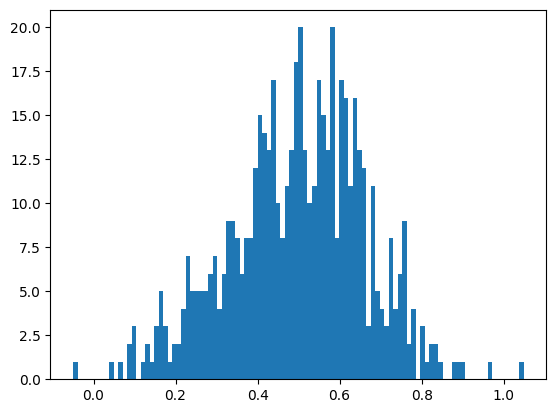

In [23]:
plt.hist(ths[:, 0, 0], bins=100)
plt.show()

(array([ 72.,  10.,   3.,   8.,  10.,   9.,  12.,  21.,  55., 346.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

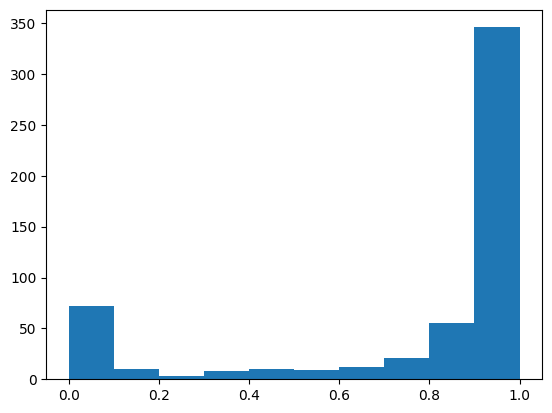

In [24]:
plt.hist(precision_test)